In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

Bernoulli = tf.contrib.distributions.Bernoulli
st = tf.contrib.bayesflow.stochastic_tensor

data = input_data.read_data_sets("MNIST_data/", one_hot=True).test
data.images[data.images>0.5] = 1.0
data.images[data.images<=0.5] = 0.0

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [26]:
batch_size = 40
lr = 1e-3
ns = 1
eps = 1e-7

ST = False
bl = tf.constant(0.0)
vr = tf.constant(0.0)

In [27]:
def add_layer(inputs, wn, bn, in_dim, out_dim, af=None):
    try:
        w = tf.get_variable(wn, [in_dim, out_dim], initializer=tf.truncated_normal_initializer)
        b = tf.get_variable(bn, [1, out_dim], initializer=tf.truncated_normal_initializer)
    except:
        with tf.variable_scope(tf.get_variable_scope(), reuse=True):
            w = tf.get_variable(wn, [in_dim, out_dim], initializer=tf.truncated_normal_initializer)
            b = tf.get_variable(bn, [1, out_dim], initializer=tf.truncated_normal_initializer)
    if af is None:
        return tf.matmul(inputs, w) + b
    return af(tf.matmul(inputs, w) + b)

def sample(h, dim, s=1):
    ss = st.StochasticTensor(dist=Bernoulli(probs=h, dtype=tf.float32),
                             dist_value_type=st.SampleValue(shape=s)).value()
    ss = tf.reshape(ss, [ns*batch_size, dim])
    return ss

def plt_figure(loss, lb=0, hb=500):
    plt.ylim(lb, hb)
    plt.plot(loss)
    plt.show()

In [28]:
x = tf.placeholder(tf.float32, [None, 392])

h1 = add_layer(x, "wxh1", "bxh1", 392, 200, tf.nn.sigmoid)
h1 = tf.clip_by_value(h1, eps, 1.0-eps)

if ST is False:
    sh1 = tf.stop_gradient(sample(h1, 200, ns))
else:
    sh1 = tf.stop_gradient(sample(h1, 200, ns)-h1)+h1

h2 = add_layer(sh1, "wh1h2", "bh1h2", 200, 200, tf.nn.sigmoid)
h2 = tf.clip_by_value(h2, eps, 1.0-eps)

if ST is False:
    sh2 = tf.stop_gradient(sample(h2, 200))
else:
    sh2 = tf.stop_gradient(sample(h2, 200)-h2)+h2
    
y = add_layer(sh2, "wh2y", "bh2y", 200, 392, tf.nn.sigmoid)
y_sum = tf.reduce_sum(tf.reshape(y, [ns, batch_size, 392]), 0)

y_ = tf.placeholder(tf.float32, [None, 392])
y_expect = tf.clip_by_value(y_*y_sum/ns + (1.0-y_)*(1.0-y_sum/ns), eps, 1.0-eps)
loss_y = tf.reduce_mean(-tf.reduce_sum(tf.log(y_expect), 1))

_y = tf.tile(y_, [ns,1])
y = tf.clip_by_value(_y*y + (1.0-_y)*(1.0-y), eps, 1.0-eps)
loss = -tf.reduce_sum(tf.log(y), 1, keep_dims=True)

In [29]:
def ST():
    train_step = tf.train.AdamOptimizer(lr).minimize(loss_y)
    return train_step, loss_y

In [30]:
def LR():
    loss_h2 = tf.reduce_mean(tf.reduce_sum(
                            tf.stop_gradient(loss) * tf.log(sh2*h2+(1.0-sh2)*(1.0-h2)), 1))
    loss_h1 = tf.reduce_mean(tf.reduce_sum(
                            tf.stop_gradient(loss) * tf.log(sh1*tf.tile(h1,[ns,1])+(1.0-sh1)*(1.0-tf.tile(h1,[ns,1]))), 1))
    
    train_step = tf.train.AdamOptimizer(lr).minimize(loss_y+loss_h2+loss_h1)
    return train_step, loss_y

In [31]:
def muProp():
    ch1 = add_layer(h1, "wh1h2", "bh1h2", 200, 200, tf.nn.sigmoid)
    ch1 = add_layer(ch1, "wh2y", "bh2y", 200, 392, tf.nn.sigmoid)
    ch1 = tf.clip_by_value(y_*ch1+(1.0-y_)*(1.0-ch1), eps, 1.0-eps)
    loss_ch1 = -tf.reduce_sum(tf.log(ch1), 1, keep_dims=True)
    dch1 = tf.gradients(loss_ch1, h1)[0]
    
    ch2 = add_layer(h2, "wh2y", "bh2y", 200, 392, tf.nn.sigmoid)
    ch2 = tf.clip_by_value(y_*ch2+(1.0-y_)*(1.0-ch2), eps, 1.0-eps)
    loss_ch2 = -tf.reduce_sum(tf.log(ch2), 1, keep_dims=True)
    dch2 = tf.gradients(loss_ch2, h2)[0]
    
    loss_h2 = tf.reduce_mean(tf.reduce_sum(
                            tf.stop_gradient((loss-loss_ch2-tf.reduce_sum(dch2*(sh2-h2), 1, keep_dims=True))) *
                            tf.log(sh2*h2+(1.0-sh2)*(1.0-h2)) +
                            tf.stop_gradient(dch2)*h2, 1))
    
    loss_h1 = tf.reduce_mean(tf.reduce_sum(
                            tf.stop_gradient((loss-loss_ch1-tf.reduce_sum(dch1*(sh1-h1), 1, keep_dims=True))) *
                            tf.log(sh1*h1+(1.0-sh1)*(1.0-h1)) +
                            tf.stop_gradient(dch1)*h1, 1))
    
    train_step = tf.train.AdamOptimizer(lr).minimize(loss_y+loss_h2+loss_h1)    
    return train_step, loss_y

In [32]:
def NVIL():
    alpha = 0.9
    _bl = alpha*bl + (1.0-alpha)*loss
    _vr = alpha*vr + (1.0-alpha)*tf.square(loss-_bl)
    
    ch = add_layer(x, "wh", "bh", 392, 100, tf.tanh)
    cy = add_layer(ch, "wy", "by", 100, 1)
    cy = tf.clip_by_value(cy, eps, 1.0-eps)
    loss_c = tf.reduce_mean(tf.square(tf.stop_gradient(loss-_bl)-cy))

    loss_h2 = tf.reduce_mean(tf.reduce_sum(
                            tf.stop_gradient((loss-_bl-cy)/tf.maximum(1.0,tf.sqrt(_vr))) * 
                            tf.log(sh2*h2+(1.0-sh2)*(1.0-h2)), 1))
    loss_h1 = tf.reduce_mean(tf.reduce_sum(
                            tf.stop_gradient((loss-_bl-cy)/tf.maximum(1.0,tf.sqrt(_vr))) * 
                            tf.log(sh1*h1+(1.0-sh1)*(1.0-h1)), 1))
    
    train_step = tf.train.AdamOptimizer(lr).minimize(loss_y+loss_h2+loss_h1+loss_c)
    
    return train_step, loss_y, tf.reduce_mean(_bl), tf.reduce_mean(_vr)

In [33]:
with tf.Session() as sess:
#    train_op = ST()
#    train_op = LR()
    train_op = muProp()
#    train_op = NVIL()

    ll = []
    bll = 0.0
    vrr= 0.0 
    sess.run(tf.global_variables_initializer())

    for i in range(50000):
        batch_ = data.next_batch(batch_size)[0]
        batch_xs = batch_[:,0:392]
        batch_ys = batch_[:,392:784]

        res = sess.run(train_op, {x: batch_xs, y_: batch_ys, bl: bll, vr: vrr})

        bll = res[-2]
        vrr = res[-1]

        if i%1000==0:
            ll.append(res[1])
            print i/1000, res[1],


0 1441.7 1 172.621 2 110.035 3 106.122 4 108.759 5 98.8352 6 89.9071 7 93.5319 8 94.0337 9 92.3278 10 83.7501 11 99.4171 12 93.0451 13 89.1183 14 83.9604 15 87.4118 16 92.6712 17 81.2591 18 83.3674 19 82.6973 20 87.702 21 87.2039 22 84.1058 23 82.8679 24 79.4425 25 75.6714 26 81.8864 27 85.366 28 84.4902 29 84.8911 30 75.206 31 96.0921 32 81.1166 33 87.6901 34 86.069 35 83.9799 36 84.4258 37 81.723 38 78.4654 39 79.0648 40 83.0674 41 93.05 42 78.0411 43 87.6206 44 89.0242 45 86.6339 46 76.5906 47 83.0875 48 75.9052 49 81.4729


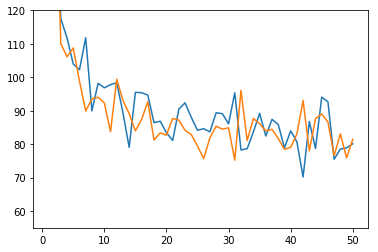

In [34]:
mpp = ll
px = np.linspace(1, 50, 50)
plt.ylim(55, 120)
plt.plot(px, mp, px, mpp)
plt.show()